Can we use a few thresholds to cleanup the CNV results? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

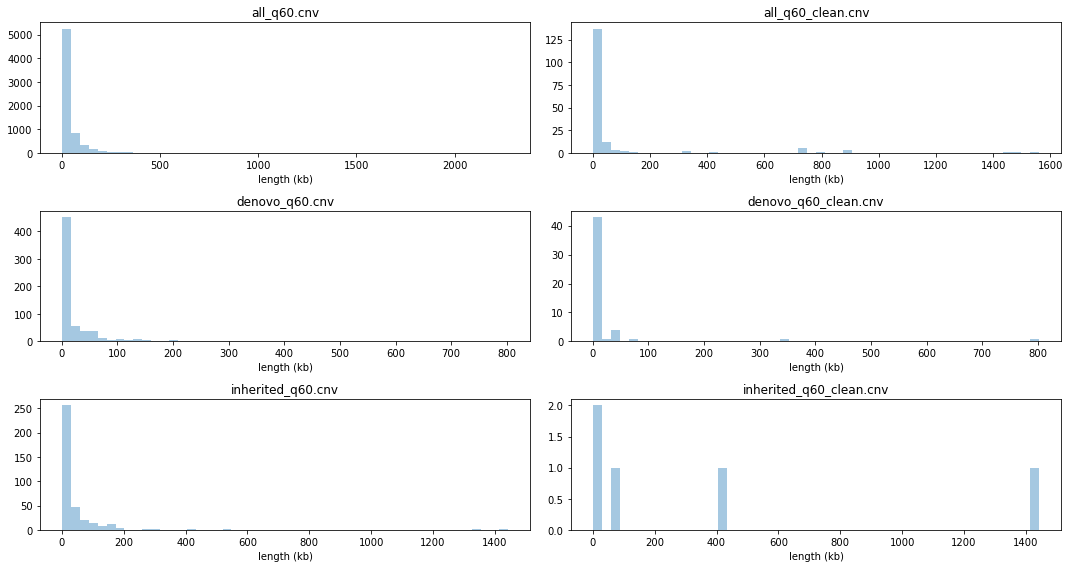

In [38]:
data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
files = glob.glob(data_dir + '/*_q60*.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('DATA') < 0:
        plt.subplot(3, 2, i)
        # the clean files have a header
        if fname.find('clean') >= 0:
            df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        else:
            df = pd.read_table(fname, header=None)
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.tight_layout()

My first impressions is about how much things change when using only the clean set. If our goal is rare variants only, than this is the way to go. 

If I look at the plot of all CNVs, anything above 500, or even 250 could be considered outliers. At least at this QC. True, we might be throwing away some interesting findings there, but maybe things to look later. Let's draw some of those cut-offs, but only in the clean set (as we're looking for rare variants). But before we do that, let's take a look at other thresholds too:

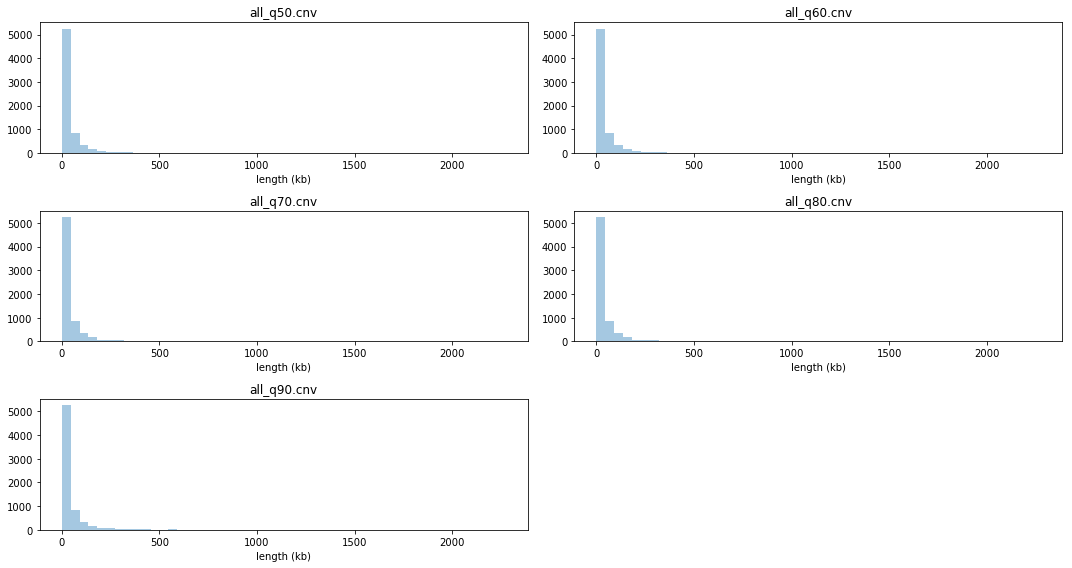

In [39]:
data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
files = glob.glob(data_dir + '/all_q?0.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('DATA') < 0:
        plt.subplot(3, 2, i)
        # the clean files have a header
        if fname.find('clean') >= 0:
            df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        else:
            df = pd.read_table(fname, header=None)
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.tight_layout()

Yep, that seems to be a reasonable cut-off. Let's run PLINK then:

In [51]:
%%bash

module load plink/1.07

cd ~/data/cnv/xhmm_multikids
for q in 50 60 70 80 90; do
    for cnvtype in all denovo inherited; do
        for qc in '' '_clean'; do
            for kb in 250 500; do
                cnvname=${cnvtype}_q${q}${qc}.cnv
                # whole burden
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-check-no-overlap --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_burden;
                # gene sets
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset genes.txt --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_genes;
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_brainGenes;
                # subtypes only
                for sub in del dup; do
                    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-${sub} --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}Burden;
                    # gene sets
                    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                        --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                        --cnv-subset genes.txt --cnv-${sub} --cnv-max-kb $kb \
                        --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}Genes;
                    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                        --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                        --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                        --cnv-max-kb $kb \
                        --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}BrainGenes;
                done;
            done;
        done;
    done;
done


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_q50_lenLT250_burden.log ]
Analysis started: Wed Jan 24 16:55:48 2018

Options in effect:
	--map all_q50.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_q50.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--cnv-max-kb 250
	--out all_q50_lenLT250_burden

Reading marker information from [ all_q50.cnv.map ]
10101 (of 10101) markers to be included from [ all_q50.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Readi

**Also, remember that PLINK has a built in threshold of 20KB for minimum length!**

OK, let's plot them again to see what we find:

In [43]:
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']

# cleaning up the data for this analysis
fid = open('/home/sudregp/data/cnv/exclude.txt', 'r')
exclude_list = [line.rstrip() for line in fid]
fid.close()
fid = open('/home/sudregp/data/cnv/exclude_multikids.txt', 'r')
exclude_list += [line.rstrip() for line in fid]
fid.close()

trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if (fa[:4] in wes_prefix and mo[:4] in wes_prefix and
        sid[:4] in wes_prefix and sid not in exclude_list):
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)
good_kids = [t['child'] for t in trios]

print 'Working with %d samples, in %d families' % (len(samples), len(famids))

Working with 88 samples, in 20 families


In [44]:
def plot_plink_cnvs(fname, t_str, verbose=False):
    
    import plotly.graph_objs as go
    from plotly import tools

    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    df.head()

    x_red, x_green, red, green, xticks = [], [], [], [], []
    red_text, green_text = [], []

    # loop through families
    f = 0
    for fam in famids:
        fam_kids = [t['child'] for t in trios if t['famid'] == fam]
        found = False
        for kid in fam_kids:
            if kid in good_kids:
                found = True
                idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
                if kid in affected:
                    red.append(int(df.iloc[idx]['NSEG']))
                    x_red.append(f)
                    red_text.append(kid)
                else:
                    green.append(int(df.iloc[idx]['NSEG']))
                    x_green.append(f)
                    green_text.append(kid)
        # only increase counter if we added a kid
        if found:
            xticks.append(fam)
            f += 1

    fig = go.Figure()
                
    trace0 = go.Scatter(
        x = x_red,
        y = red,
        mode = 'markers',
        name = 'affected',
        marker = dict(size = 10, color = 'red'),
        text = red_text,
        hoverinfo='text+y',
        showlegend = True
    )
    trace1 = go.Scatter(
        x = x_green,
        y = green,
        mode = 'markers',
        name = 'unaffected',
        marker = dict(size = 10, color = 'green'),
        hovertext = green_text,
        hoverinfo='text+y',
        showlegend = True
    )
    fig['data'] = [trace0, trace1]
    fig['layout'].update(height=400, width=800, title=t_str,
                             xaxis1=dict(tickvals=range(len(xticks)),
                                        ticktext=xticks,
                                        zeroline = False),
                             hovermode='closest')
    iplot(fig)
    
    # print family order
    if verbose:
        score = []
        for x in range(max(x_green + x_red)):
            idx = [i for i, val in enumerate(x_red) if val == x]
            if len(idx) == 0:
                aff = 0
            else:
                aff = red[idx[0]]
            idx = [i for i, val in enumerate(x_green) if val == x]
            if len(idx) == 0:
                unaff = 0
            else:
                unaff = max([green[i] for i in idx])
            score.append(aff - unaff)
        order = np.argsort(score)[::-1]
        fam_names = fig.layout.xaxis1['ticktext']
        disrupted = [fam_names[v] for v in order if score[v] > 0]
        print 'Best disrupted:', ', '.join(disrupted)
        protected = [fam_names[v] for v in order[::-1] if score[v] < 0]
        print 'Best protected:', ', '.join(protected)

In [47]:
import glob

data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
files = glob.glob(data_dir + '/*q60*clean*LT*cnv.indiv')
files2 = [f for f in files if f.find('all') < 0]
files2.sort()
for f in files2:
    t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
    plot_plink_cnvs(f, t_str, verbose=True)

Best disrupted: 
Best protected: 


Best disrupted: 10406, 10164, 10090, 855, 1976
Best protected: 10131, 10369, 1895


Best disrupted: 
Best protected: 


Best disrupted: 10406, 855, 10369, 1976, 10448
Best protected: 1895


Best disrupted: 10406, 855, 10369, 10448
Best protected: 1895


Best disrupted: 
Best protected: 


Best disrupted: 10164, 10090
Best protected: 10369, 10131, 10448


Best disrupted: 10164, 10090
Best protected: 10131, 10369, 10448


Best disrupted: 10406, 10164, 10090, 855
Best protected: 10131, 1895


Best disrupted: 
Best protected: 


Best disrupted: 10406, 10164, 10090, 855, 1976
Best protected: 10131, 10369, 1895


Best disrupted: 
Best protected: 


Best disrupted: 10406, 855, 10369, 1976, 10448
Best protected: 1895


Best disrupted: 10406, 855, 10369, 10448
Best protected: 1895


Best disrupted: 
Best protected: 


Best disrupted: 10164, 10090
Best protected: 10369, 10131, 10448


Best disrupted: 10164, 10090
Best protected: 10131, 10369, 10448


Best disrupted: 10406, 10164, 10090, 855
Best protected: 10131, 1895


Best disrupted: 
Best protected: 


Best disrupted: 1976, 10448
Best protected: 855


Best disrupted: 
Best protected: 


Best disrupted: 1976, 10448
Best protected: 855


Best disrupted: 10448
Best protected: 855


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 


Best disrupted: 
Best protected: 


Best disrupted: 10448
Best protected: 855


Best disrupted: 
Best protected: 


Best disrupted: 1976, 10448
Best protected: 855


Best disrupted: 
Best protected: 


Best disrupted: 1976, 10448
Best protected: 855


Best disrupted: 10448
Best protected: 855


Best disrupted: 
Best protected: 


Best disrupted: 1976
Best protected: 


Best disrupted: 1976
Best protected: 


Best disrupted: 1976, 10448
Best protected: 855


These results would lead me to investigate further denovo_q60_clean_lenBT250_delBurden, but 500 also works. Let's see what we get there:

In [49]:
%%bash
cd /home/sudregp/data/cnv/xhmm_multikids/

for kid in CLIA_400205 CLIA_400216 CLIA_400204 CCGO_800980 CLIA_400178; do
    echo $kid
    grep -B 3 $kid denovo_q60_clean_lenLT250_delGenes.reg | grep RANGE;
done

CLIA_400205
RANGE (+/- 0kb )  [ 8 30689059 30706533 TEX15 ]
CLIA_400216
RANGE (+/- 0kb )  [ X 139865424 139866723 CDR1 ]
CLIA_400204
RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
CCGO_800980
RANGE (+/- 0kb )  [ X 80369199 80457441 HMGN5 ]
CLIA_400178
RANGE (+/- 0kb )  [ 1 62901974 62917475 USP1 ]
RANGE (+/- 0kb )  [ 1 62920396 63154039 DOCK7 ]
RANGE (+/- 0kb )  [ 1 67390577 67454302 MIER1 ]
RANGE (+/- 0kb )  [ 1 93811477 93828148 DR1 ]
RANGE (+/- 0kb )  [ 2 48010220 48034092 MSH6 ]
RANGE (+/- 0kb )  [ 2 48034058 48132932 FBXO11 ]
RANGE (+/- 0kb )  [ 2 174771186 174830430 SP3 ]
RANGE (+/- 0kb )  [ 3 42642146 42690233 NKTR ]
RANGE (+/- 0kb )  [ 3 180319917 180336135 TTC14 ]
RANGE (+/- 0kb )  [ 3 180331795 180397283 CCDC39 ]
RANGE (+/- 0kb )  [ 4 17812435 17846487 NCAPG ]
RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
RANGE (+/- 0kb )  [ 4 68424445 68472616 STAP1 ]
RANGE (+/- 0kb )  [ 4 68481478 68566889 UBA6 ]
RANGE (+/- 0kb )  [ 4 100817406 100867883 DNAJB14 ]
RANGE (+/- 0kb )  [ 4 1

Two hits in the X chromossome? I didn't even remember we were looking into that... need to take a closer look. But LCORL is in 2, which is nice.

In [52]:
fid = open('/home/sudregp/data/cnv/xhmm_multikids/denovo_q60_clean_lenLT250_delGenes.reg')
genes = {}
for line in fid:
    if line.find('RANGE') >= 0:
        gene = line.split(' ')[-2]
        genes[gene] = 0
    elif line.find('DUP') > 0 or line.find('DEL') > 0:
        genes[gene] += 1
fid.close()
df = pd.DataFrame.from_dict(genes, orient='index')
df.columns = ['count']
df.sort_values(by='count', ascending=False).head(10)

,count
LCORL,2
CHD9,2
ABHD13,2
CCDC73,1
MED13,1
ETNK1,1
DNAJB14,1
CREBRF,1
CCDC168,1
LYSMD3,1


In [53]:
dfs = df.sort_values(by='count', ascending=False).head(3)
for index, count in dfs.iterrows():
    nlines = count[0]
    gene = index
    fid = open('/home/sudregp/data/cnv/xhmm_multikids/denovo_q60_clean_lenLT250_delGenes.reg')
    for line in fid:
        if line.find(gene) >= 0:
            print line.rstrip()
            for i in range(nlines + 1):
                line = fid.next()
                print line.rstrip()
    fid.close()

RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400178        2    4     17845860     17879761    DEL     33.9        1   0.1898   0.1898
   1   CLIA_400204        2    4     17878089     17878822    DEL    0.733        1 0.004109 0.004109
RANGE (+/- 0kb )  [ 16 53088944 53361414 CHD9 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400178        2   16     53358611     53361477    DEL    2.866    0.978  0.01029  0.01029
   1   CLIA_400203        1   16     53358753     53361477    DEL    2.724   0.9769 0.009768  0.00977
RANGE (+/- 0kb )  [ 13 108870762 108886603 ABHD13 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400158        1   13    108882417    108886344    DEL    3.927        1   0.2479   0.2479
   1   CLIA_400178        2   13    

# TODO
 * gene based analysis? adhd only?
 * inherited results?
 * run non-clean set as well, as it's possible that a combination of common variants is behind this, not only rare
 * correlations with other variables?
 * what's up with the chrX hits?
 * run unique multiplex with ADHD to find inherited variables?